# ACIS Analysis Caveat: Always use  weighted responses for source in chip gaps

See Helpdesk ticket #21359.

Quick snipet:

When we run `mkarf` we use `detsys=ACIS-n` for a **single** ACIS chip.  Any flux or effective area on any other chip is lost.  We could choose to run `mkarf` for each exposed chip and add them -- that would help.  

However, `mkarf` assumes that 100% of the flux is contained in `sourcepixelx`,`sourcepixely`; this is
not ever the case, especially as we move even slightly off-axis.

Instead, we just need to create a weighted ARF using `mkwarf`.  Technically even here would could do a better job.  The input to `sky2tdet` is the _counts_ image.  Ideally it should be _exposure corrected_. But this is a chicken-n-egg thing (not to mention energy dependence) so we happily ignore this.



## Overview

- Download data
- Select source and region that falls in chip gap.
- Plot data in gap
- Plot dither trace traversing gap.
- Simulate PSF
- Run `dither_region` tool to compute fraction of AREA and PSF lost in gap vs. time.
- Plot per-chip fraction of area
- Run `specextract` to create weighted and unweighted responses
- Diff and plot to compare
- Run `modelflux` to compute counts-to-flux conversions using weighted and unweighted responses
- Compare
- Plot per-chip **PSF** fraction lost in gap


## Download data and setup

In [1]:
obsid=3752
/bin/rm -rf ${obsid}
download_chandra_obsid ${obsid} evt2,msk,bpix,asol,fov,flt,mtl


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  evt2     fits       29 Mb  ####################          < 1 s  42332.6 kb/s
  bpix     fits       95 Kb  ####################          < 1 s  1656.7 kb/s
  fov      fits        6 Kb  ####################          < 1 s  207.9 kb/s
  asol     fits       33 Mb  ####################          < 1 s  37635.4 kb/s
  flt      fits        7 Kb  ####################          < 1 s  247.2 kb/s
  msk      fits        5 Kb  ####################          < 1 s  191.1 kb/s
  mtl      fits        5 Mb  ####################          < 1 s  32983.4 kb/s

      Total download size for ObsId 3752 = 68 Mb
      Total download time for ObsId 3752 = 2 s



In [2]:
#Make life a little easier
evt=`/bin/ls ${obsid}/primary/acisf*evt2.fits.gz`
asp=`/bin/ls ${obsid}/primary/pcadf*asol1.fits.gz`
msk=`/bin/ls ${obsid}/secondary/*msk1.fits.gz`
fov=`/bin/ls ${obsid}/primary/*fov1.fits.gz`
mtl=`/bin/ls ${obsid}/secondary/*mtl1.fits.gz`
bpx=`/bin/ls ${obsid}/primary/*bpix1.fits.gz`
flt=`/bin/ls ${obsid}/secondary/*flt1.fits.gz`

In [3]:
/bin/ls -1 $evt $asp $msk $fov $mtl $bpx $flt

3752/primary/acisf03752N003_evt2.fits.gz
3752/primary/acisf03752_000N003_bpix1.fits.gz
3752/primary/acisf03752_000N003_fov1.fits.gz
3752/primary/pcadf181258137N003_asol1.fits.gz
3752/secondary/acisf03752_000N003_flt1.fits.gz
3752/secondary/acisf03752_000N003_msk1.fits.gz
3752/secondary/acisf03752_000N003_mtl1.fits.gz


## Determine region

I'm going to create a region for a source I know to be in the chip gap.

I actually used CSC2 to find a good candidate -- don't tell anyone.

It's a fairly bright source, in a long observation so a nice example.


In [4]:
cat << EOM > ds9.reg
circle(3801.0832,3956.9799,11.669743)
EOM

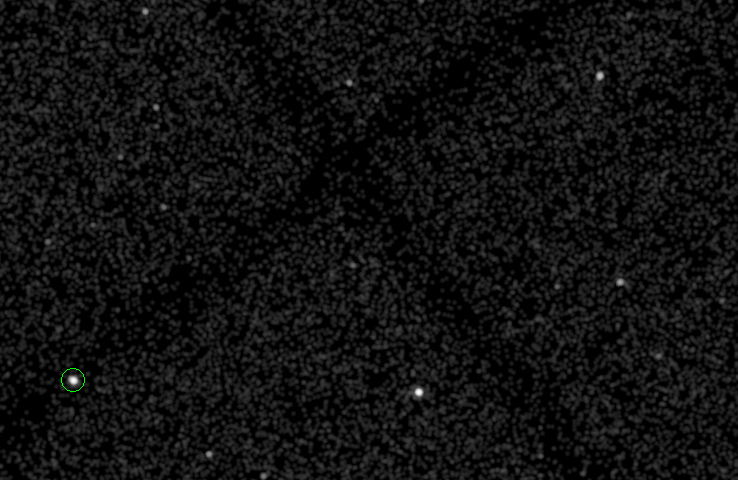

In [5]:
ds9 $evt -scale log -smooth -region ds9.reg \
  -view colorbar no -saveimage png ds9_01.png -quit

display < ds9_01.png

In [6]:
dmlist "${evt}[sky=region(ds9.reg),energy=500:7000]" counts

1035    


In [7]:
dmstat "${evt}[sky=region(ds9.reg)][cols ccd_id]" | egrep 'min:|max:'

    min:	1 	      @:	15 
    max:	3 	      @:	1 


> OK, so the source is between chips 1 and 3.

### Plot in detector coordinates

We can plot the data in `DET` coordinates to see where the source falls on the detector.

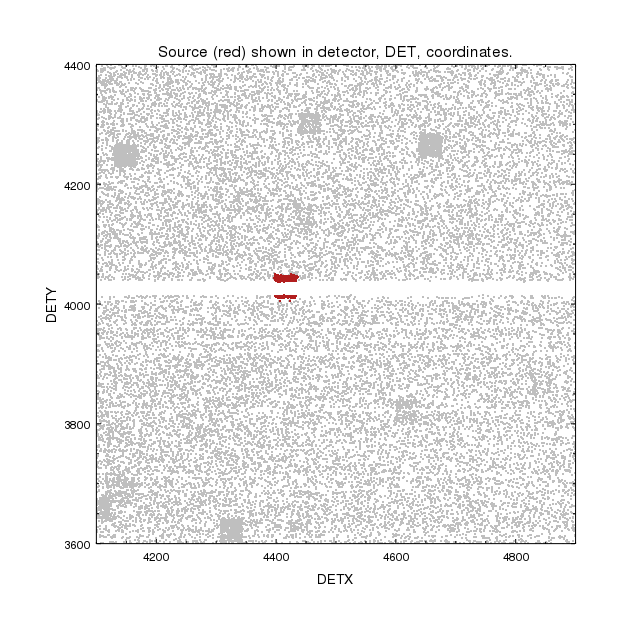

In [8]:
cat << EOM > chips_04.py

add_window(640,640)
add_curve("${evt}[ccd_id=1,3][cols detx,dety]","line.style=none symbol.style=square symbol.size=1 depth=90 *.color=gray")
add_curve("${evt}[sky=region(ds9.reg)][cols detx,dety]","line.style=none symbol.style=square symbol.size=1 depth=90 *.color=firebrick")

limits(Y_AXIS, 3700, 4300)
limits(X_AXIS, 4100, 4900)
set_data_aspect_ratio("1:1")
set_plot_xlabel("DETX")
set_plot_ylabel("DETY")
set_plot_title("Source (red) shown in detector, DET, coordinates.")

print_window("chips_04.png","export.clobber=True")
quit()
EOM

chips -n chips_04.py
display < chips_04.png

We can see the source spans two chips; and we can also see the other nearby sources in 
detector coordinates (~32pixel squares).

---

### Plot vs time


We can also plot the dither-time-trace showing the source _centroid_ vs. time


In [9]:
punlearn dmstat 
dmstat "${evt}[sky=region(ds9.reg)][bin sky=1]" cen+ verb=0
xx=`stk_read_num ")dmstat.out_cntrd_phys" 1 echo+`
yy=`stk_read_num ")dmstat.out_cntrd_phys" 2 echo+`
echo $xx $yy

3801.0962124 3956.9769799


In [10]:
cat << EOM > doit_01.py
from coords.chandra import sky_to_chandra
from pycrates import read_file
from crates_contrib.utils import write_columns
sky_x=$xx
sky_y=$yy
asolfile='$asp'
outfile='centroid_coords.fits'
xcolumn="detx"
ycolumn="dety"

tab = read_file(asolfile)

keywords = { 'INSTRUME' : "ACIS",
             'DETNAM' : "ACIS-0123",
             'RA_NOM' : tab.get_key_value("RA_NOM"),
             'DEC_NOM' : tab.get_key_value("DEC_NOM"),
             'SIM_X' : tab.get_key_value("SIM_X"),
             'SIM_Y' : tab.get_key_value("SIM_Y"),
             'SIM_Z' : tab.get_key_value("SIM_Z")
             }

time = tab.get_column("time").values
ra = tab.get_column("ra").values
dec = tab.get_column("dec").values
roll = tab.get_column("roll").values
dy = tab.get_column("dy").values
dz = tab.get_column("dz").values
dth = tab.get_column("dtheta").values

output = { 'time' : [], xcolumn : [], ycolumn : [] }

for t,r,d,l,y,z,h in zip( time,ra,dec,roll,dy,dz,dth):
    keywords["RA_PNT"] = r
    keywords["DEC_PNT"] = d
    keywords["ROLL_PNT"] = l
    keywords["DY_AVG"] = float(y)
    keywords["DZ_AVG"] = float(z)
    keywords["DTH_AVG"] = float(h)
    
    coords = sky_to_chandra( keywords, sky_x, sky_y )

    output['time'].append(t)
    output[xcolumn].append(coords[xcolumn][0])
    output[ycolumn].append(coords[ycolumn][0])

write_columns( outfile, output, colnames=['time',xcolumn,ycolumn], 
    format="fits", clobber=True)

EOM

#### Uncomment to run, takes a while with this dataset!
#~python doit_01.py

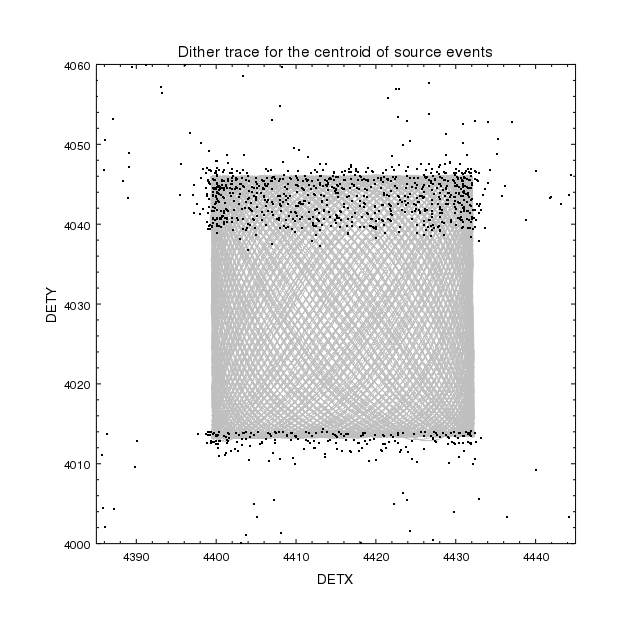

In [11]:
cat << EOM > chips_05.py

add_window(640,640)
add_curve("${evt}[ccd_id=1,3][cols detx,dety]",
    "line.style=none symbol.style=square symbol.size=1 depth=100 *.color=black")

add_curve("centroid_coords.fits[cols detx,dety]", "symbol.style=none *.color=gray depth=90")

limits(Y_AXIS, 4010, 4050)
limits(X_AXIS, 4385, 4445)

set_plot_xlabel("DETX")
set_plot_ylabel("DETY")
set_plot_title("Dither trace for the centroid of source events")
set_data_aspect_ratio("1:1")
print_window("chips_05.png","export.clobber=True")
quit()
EOM

chips -n chips_05.py
display < chips_05.png

We see that there is a large overall fraction of the source flux lost into the gap.

There is a small fraction which is imaged on one of the CCDs and a larger fraction imaged on the top
CCD.  Below, we'll see these are CCD_ID 1 and CCD_ID=3 respectively.

This plot is only showing the _centroid_.  This is basically the same as the `mkarf` `sourcepixelx` and `sourcepixely` parameters.  There are source events outside this trace which are due to the 
PSF (and any possible extent of the source itself).

---


## Simulate PSF

I'm going to need the PSF later so it's more efficient if I do this here.

Really do not **need** the PSF -- I could just use the actual events image as a surrogate 
for the PSF and it would work OK -- but this may make some purists happy.

In [12]:
punlearn dmcoords
dmcoords $evt op=sky x=$xx y=$yy asol=$asp verb=0 celfmt=deg 
ra=`pget dmcoords ra`
dec=`pget dmcoords dec`
echo $ra $dec

29.4606243954435 37.75439338867463


In [13]:
source $ASCDS_INSTALL/marx-5.3.3/setup_marx.sh

# MARX doesn't read gzip'ed asol files :frown:
gunzip -c $asp > asol.fits


punlearn simulate_psf
simulate_psf infile=$evt asol=asol.fits out=src_in_gap \
  ra=$ra dec=$dec spectrum= mono=1.0 flux=1e-3 \
  pile- ideal- ext+ bin=1 minsize=256 numiter=1 
  
/bin/rm asol.fits 

simulate_psf
          infile = 3752/primary/acisf03752N003_evt2.fits.gz
         outroot = src_in_gap
              ra = 29.4606243954435
             dec = 37.75439338867463
    spectrumfile = 
      monoenergy = 1
            flux = 0.001
       simulator = marx
         rayfile = 
       projector = marx
     random_seed = -1
            blur = 0.07000000000000001
  readout_streak = no
          pileup = no
           ideal = no
        extended = yes
         binsize = 1
          numsig = 7
         minsize = 256
         numiter = 1
        keepiter = no
        asolfile = asol.fits
       marx_root = /export/ciao-4.10/marx-5.3.3
         verbose = 1
            mode = ql

Started check_setup
Finished check_setup
Performing iteration 1 of 1
Started run_marx
Finished run_marx
Started create_psf_image
Finished create_psf_image
Started create_average_image
Finished create_average_image

Final output PSF image is : src_in_gap.psf



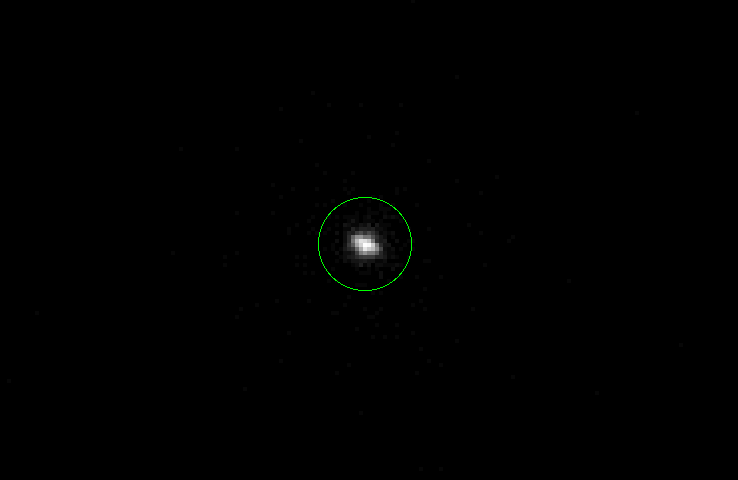

In [14]:
ds9 src_in_gap.psf -scale log -region ds9.reg \
  -zoom to 4 -view colorbar no \
  -saveimage png ds9_02.png -quit
display < ds9_02.png

Looks good.  This will come back into play later.

---

## Run how much lost in gap?

We can use the `dither_region` tool to see how much of the source region is lost
in the gap between the chips.  

We can also see how much of the region is imaged by each of the detector elements.



### Don't forget `ardlib.par`

First, we need to setup the `ardlib.par` with the observation specific badpixel files.

We tend to forget about this when we use the scripts because they do it for us, but it's really 
important here.

In [15]:
punlearn ardlib
acis_set_ardlib $bpx abs-

Updated ardlib parameter file: /home/kjg/cxcds_param4/ardlib.par
  AXAF_ACIS0_BADPIX_FILE -> 3752/primary/acisf03752_000N003_bpix1.fits.gz[BADPIX0]
  AXAF_ACIS1_BADPIX_FILE -> 3752/primary/acisf03752_000N003_bpix1.fits.gz[BADPIX1]
  AXAF_ACIS2_BADPIX_FILE -> 3752/primary/acisf03752_000N003_bpix1.fits.gz[BADPIX2]
  AXAF_ACIS3_BADPIX_FILE -> 3752/primary/acisf03752_000N003_bpix1.fits.gz[BADPIX3]
  AXAF_ACIS4_BADPIX_FILE -> CALDB
  AXAF_ACIS5_BADPIX_FILE -> 3752/primary/acisf03752_000N003_bpix1.fits.gz[BADPIX5]
  AXAF_ACIS6_BADPIX_FILE -> CALDB
  AXAF_ACIS7_BADPIX_FILE -> 3752/primary/acisf03752_000N003_bpix1.fits.gz[BADPIX7]
  AXAF_ACIS8_BADPIX_FILE -> CALDB
  AXAF_ACIS9_BADPIX_FILE -> CALDB


and now run `dither_region`.

> Again, I'm going to include PSF in  here at this point just for efficiency.  this tool can be
> slow for larger regions and|or long exposures, so best to supply all inputs and let it go.


In [16]:
punlearn dither_region

dither_region infile=$asp outfile=dr.out region='region(ds9.reg)' \
  wcsfile=$evt maskfile=$msk mode=h clob+ verb=0 \
  psffile=src_in_gap.psf

> Hint: when runing interactively, use verb=3 to get % complete.  Not a good idea in 
> a notebook though.

Now plot the the fraction of the source area vs. time.  We actually plot 
the fraction of source area on each chip vs. time

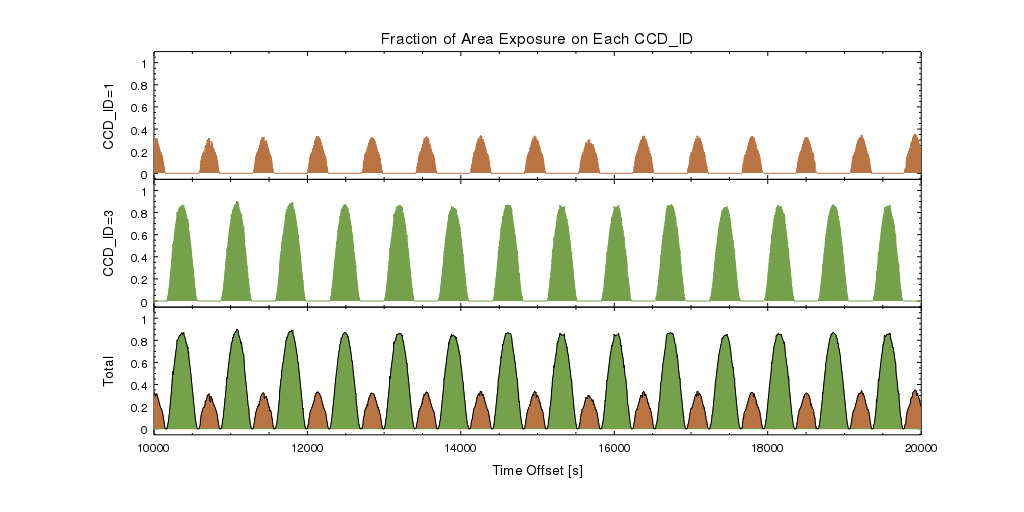

In [17]:
cat << EOM > chips_01.py

tab = read_file("dr.out")
times = tab.get_column("time").values
fracs = tab.get_column("area_chip_frac").values
tfrac = tab.get_column("fracarea").values

colors = [ '4C4F4B', 'BA7443', '006AFF','74A14A' ]
chips = [1,3]
nplots=len(chips)+1
times = times - times[0]

clear()
add_window(1024,512)
strip_chart(nplots)
set_current_plot("plot1")
set_plot_title("Fraction of Area Exposure on Each CCD\_ID")
for idx,ccd in enumerate(chips):
    set_current_plot("plot{}".format(idx+1))
    add_histogram( times, fracs[:,ccd], "*.color={} fill.style=solid fill.opacity=1.0".format(colors[ccd]))
    set_plot_ylabel("CCD\_ID={}".format(ccd))
    set_current_plot("plot{}".format(nplots))
    add_histogram( times, fracs[:,ccd], "*.color={} fill.style=solid fill.opacity=1.0".format(colors[ccd]))

add_curve(times,tfrac, "symbol.style=none")
set_plot_ylabel("Total")
set_plot_xlabel("Time Offset [s]")

for ii in range(len(chips)):
    bind_axes( "plot{}".format(ii+2), "ay1", "plot1", "ay1")

limits(Y_AXIS, AUTO, 1.1)
limits(X_AXIS, 10000, 20000 )

print_window("chips_01.png","export.clobber=True")
quit()
EOM

chips -n chips_01.py
display < chips_01.png

I zoomed into a "short" time range to show the details.

We can see the fraction of the region going back and forth between the two detectors and purely by dumb luck not actually covering both CCDs at the same time.  If I'd increase the radius it would.

We see `CCD_ID=1` (top) has a lower fraction of the area which matches the bottom chip shown in `DET` coordinates above.  It maxes out to ~30% of the area of the region being imaged.

The middle histogram for `CCD_ID=3` goes upto ~90%. 




---

## Make responses

Alright, so now we know the source does dither across multiple chips and we have a sense of 
by how much, so let's see how this affects the responses.   Specifically the _ARF_.

I'll run `specextract` twice, once to create weights responses, and then to create the 
unweighted responses.


In [18]:
punlearn specextract ardlib

In [19]:
specextract infile="${evt}[sky=region(ds9.reg)]" \
  outroot=weighted bkgresp=no weight=yes \
  clob+ mode=h

Running specextract
Version: 11 May 2018

Using event file 3752/primary/acisf03752N003_evt2.fits.gz[sky=region(ds9.reg)]

Aspect solution file 3752/primary/pcadf181258137N003_asol1.fits found.

Bad-pixel file 3752/primary/acisf03752_000N003_bpix1.fits.gz found.

Mask file 3752/secondary/acisf03752_000N003_msk1.fits found.

chipx=1033 for ACIS-3; using chipx=1024 for FEF and RMF look up.

Setting bad pixel file 

Extracting src spectra 

Creating src ARF 

Creating src RMF 

Using mkacisrmf...

Grouping src spectrum 

Updating header of weighted.pi with RESPFILE and ANCRFILE keywords.

Updating header of weighted_grp.pi with RESPFILE and ANCRFILE keywords.



In [20]:
specextract infile="${evt}[sky=region(ds9.reg)]" \
  outroot=unweighted bkgresp=no weight=no \
  clob+ mode=h

Running specextract
Version: 11 May 2018

Using event file 3752/primary/acisf03752N003_evt2.fits.gz[sky=region(ds9.reg)]

Aspect solution file 3752/primary/pcadf181258137N003_asol1.fits found.

Bad-pixel file 3752/primary/acisf03752_000N003_bpix1.fits.gz found.

Mask file 3752/secondary/acisf03752_000N003_msk1.fits found.

chipx=1033 for ACIS-3; using chipx=1024 for FEF and RMF look up.

Setting bad pixel file 

Extracting src spectra 

Creating src ARF 

Creating src RMF 

Using mkacisrmf...

Grouping src spectrum 

Updating header of unweighted.pi with RESPFILE and ANCRFILE keywords.

Updating header of unweighted_grp.pi with RESPFILE and ANCRFILE keywords.



### Check processing history

Just for fun, we can check the processing history in the files to see that they were created 
with `mkwarf` for the weighted responses and `mkarf` for the unweighted responses.


In [21]:
dmhistory weighted.arf mkwarf | tr " " "\012"

# dmhistory (CIAO 4.10): WARNING: Found and corrected "ardlib" library parameters

mkwarf
infile="/tmp/tmp2f6zdgv1_tdet[wmap]"
outfile="weighted.arf"
weightfile="/tmp/tmpswa3pybg.wfef"
spectrumfile=""
egridspec="0.3:11.0:0.01"
pbkfile=""
threshold="0"
feffile="CALDB"
mskfile="/data/lenin2/Projects/ChipGap/3752/secondary/acisf03752_000N003_msk1.fits"
asolfile=""
mirror="HRMA"
detsubsysmod=""
dafile="CALDB"
ardlibpar="ardlib"
geompar="geom"
clobber="yes"
verbose="1"




In [22]:
dmhistory unweighted.arf mkarf | tr " " "\012"

mkarf
asphistfile="/tmp/tmpm46d27rv_asphist3"
outfile="unweighted.arf"
sourcepixelx="3800.413457"
sourcepixely="3956.310157"
engrid="0.3:11.0:0.01"
obsfile="3752/primary/acisf03752N003_evt2.fits.gz"
pbkfile=""
dafile="CALDB"
mirror="HRMA"
detsubsys="ACIS-I3"
grating="NONE"
maskfile="/data/lenin2/Projects/ChipGap/3752/secondary/acisf03752_000N003_msk1.fits"
ardlibparfile="ardlib.par"
geompar="geom"
verbose="1"
clobber="yes"




> Note in the `mkarf` the `detsubsys="ACIS-I3"` parameter setting.  Only 1 CCD
> was used to compute the effective area.  It **is** the chip with the largest
> fraction of the area which is good -- but that's not guaranteed to be the case.

### Diff the files

Well, let's only do the first few.  Skip the headers/etc since the 
two tools output slightly different metadata.

In [23]:
dmdiff weighted.arf"[cols specresp][#row=1:20]" unweighted.arf"[cols specresp][#row=1:20]" \
  key- comment- sub- || echo

Infile 1:  weighted.arf[cols specresp][#row=1:20]
Infile 2:  unweighted.arf[cols specresp][#row=1:20]


TABLE NAME: SPECRESP

-----------------------
TABLE VALUE DIFFERENCES
-----------------------

Message:                             Row:        Column:              Value(s):                    Diff:
--------                             ----        -------              ---------                    -----
Values are not equal                   1        SPECRESP 0.0453275218605995  0.04016999527812  -0.00515753 (-11.4 %)
Values are not equal                   2        SPECRESP 0.167393743991852  0.148336440324783   -0.0190573 (-11.4 %)
Values are not equal                   3        SPECRESP 0.280267238616943  0.248333737254143   -0.0319335 (-11.4 %)
Values are not equal                   4        SPECRESP 0.440861970186234  0.390601396560669   -0.0502606 (-11.4 %)
Values are not equal                   5        SPECRESP 0.643063545227051  0.569714426994324   -0.0733491 (-11.4 %)
Values

So around 11% difference, kinda seems low.  

### Plot arfs

Let's plot to see if we can figure things out

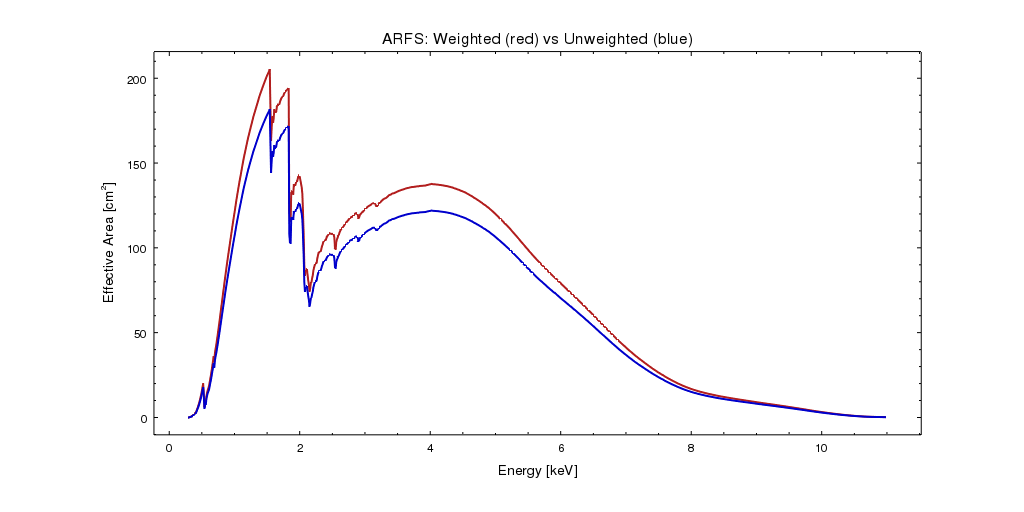

In [24]:
cat << EOM > chips_02.py
add_window(1024,512)
add_curve("weighted.arf[cols energ_lo,specresp]", "symbol.style=none *.color=firebrick line.thickness=2")
add_curve("unweighted.arf[cols energ_lo,specresp]", "symbol.style=none *.color=mediumblue line.thickness=2")
set_plot_xlabel("Energy [keV]")
set_plot_ylabel("Effective Area [cm^2]")
set_plot_title("ARFS: Weighted (red) vs Unweighted (blue)") 
print_window("chips_02.png","export.clobber=True")
quit()
EOM

chips -n chips_02.py
display < chips_02.png


> The fact that max(specresp) is ~ 200cm^2 is due to flux lost between the chips.
> A fully exposed region should max out around 600cm^2 

## How does this affect flux estimates

Our helpdesk user claimed _2 orders of magnitude_ changes in flux.  That's really hard to demonstrate.  It must have been some narrow energy band 
or some bizarre region.

Rather than fitting (and having to show my ignorance in what physical model I should be using for
this unknown source) I will just use the "PIMMS-like" approach.  

Here I run `modelflux` using the same absorbed powerlaw model using the weighted and unweighted 
responses.  I set `rate=1` just so we we a nice unit-conversion factor for the photon and energy fluxes.



In [25]:
# Setup parameters common to both runs
punlearn modelflux
pset modelflux \
  op=rate rate=1.0 \
  model=xspowerlaw.pow1 paramvals=pow1.PhoIndex=2.0 \
  absmodel=xsphabs.abs1 absparams=abs1.nH=0.05 \
  emin=.5 emax=7


In [26]:
# Weighted responses

modelflux arf=weighted.arf rmf=weighted.rmf mode=h verb=0
pdump modelflux | grep flux
ww=`pget modelflux pflux`

pflux='0.010477'
flux='2.5959e-11'
upflux='0.012406'
uflux='2.8257e-11'


In [27]:
# Un-weighted responses

modelflux arf=unweighted.arf rmf=unweighted.rmf mode=h verb=0
pdump modelflux | grep flux
uu=`pget modelflux pflux`

pflux='0.011835'
flux='2.9325e-11'
upflux='0.014014'
uflux='3.1921e-11'


In [28]:
# Diff
python -c "print( ($uu - $ww )/$ww )"

0.12961725684833442



> So for this dataset, the difference between using a weighted vs unweighted 
> ARF is ~ **13%**


## PSF Fraction

From the above plot, we might think we'd expect to see ~30% lower fluxes instead of the 13% we
are seeing.

Why?

It is because the counts in the region are not _uniformly_ distributed in that region.

What we should look at is the fraction of the **PSF** rather than the fraction of the
area of the region.


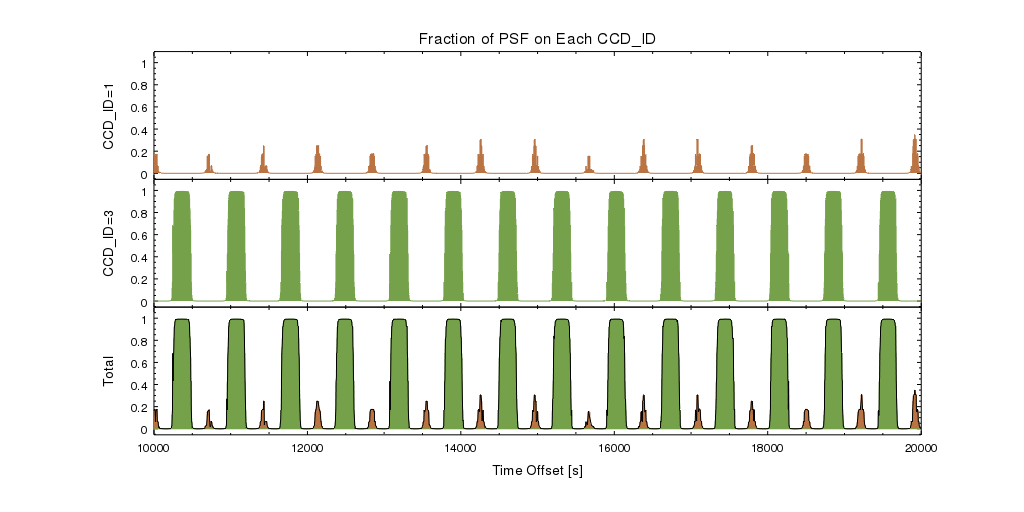

In [29]:
# Make same plot as above, but use the PSF fractions instead of region area columns

cat chips_01.py | \
  sed 's,chips_01,chips_03,g' | \
  sed 's,area_chip_frac,psf_chip_frac,g' | \
  sed 's,fracarea,psffrac,g' | \
  sed 's,Area Exposure,PSF,g' > chips_03.py

chips -n chips_03.py
display < chips_03.png


> Since the PSF isn't flat -- that is the distribution of counts withing the region(ds9.reg) are
> not flat, the fraction of the source area and the fraction of the source PSF are different.


> There is a secondary energy effect which I'm happy to ignore.

Now we see that PSF fraction wise, it is 100% (or very close to it) for a larger part of the 
dither pattern and the fraction _lost_ on `CCD_ID=1` is less than ~20%, though unlike above it does reach 
down to ~0% for a noticeable duration.